            จงออกแบบและทำการทดลอง Minimum Risk Bayes Decision Theoretic Classifier ทุก function ควรจะถูกออกแบบให้ independent ต่อกัน สำหรับการบ้านนี้ให้สมมุตว่า ทุก conditional density function เป็น multivariate normal และสามารถ estimate แต่ละ parameter โดยใช้วิธี Maximum Likelihood
            สำหรับ data set นี้ ควรตั้งให้ loss function เป็น 0-1 loss function เพื่อที่ จะได้ “best average classification” และสามารถที่จะตั้งสมมุติฐานได้ว่าแต่ละ class มี a priori probability ที่ เท่ากัน (แต่ไม่ควรที่จะ hard coded)
            ให้ใช้ 10% cross validation และทำการทดสอบ algorithm กับ TWOCLASS data set แต่ละ pass ควรจะมี Output ดังนี้
            1. Mean vectors และ Covariance matrices
            2. Confusion matrix
            3. Error estimates
            4. Classification information ใน test vectors
            และสำหรับ  data set ทั้งชุด ให้หา mean vectors และ Covariance matrices (actual training data).
            ให้ทำการทดลองโดยใช้ทั้ง 4 features และใช้เพียง features ที่ 1 และ 2 จากการทดลองทั้งหมดจะสรุปผลการทดลองได้อย่างไร

"Design and conduct an experiment for the Minimum Risk Bayes Decision Theoretic Classifier. Each function should be designed to be independent of each other. For this assignment, assume that all conditional density functions are multivariate normal and that each parameter can be estimated using Maximum Likelihood.

For this data set, the loss function should be the 0-1 loss function in order to achieve the 'best average classification.' It should also allow for assumptions that each class has an equal a priori probability (but this should not be hard coded).

Use 10% cross-validation and test the algorithm with the TWOCLASS data set. Each pass of the algorithm should produce the following outputs:

Mean vectors and Covariance matrices.
Confusion matrix.
Error estimates.
Classification information for the test vectors.
For the entire data set, find the mean vectors and Covariance matrices using the actual training data.

Conduct the experiment using all four features and then using only features 1 and 2. From all the experiments, summarize the results."

Data example:
>f1                   f2                    f3                 f4        class label

```5.91             3.09              3.74             1.17             1
6.94	2.39	3.95	1.02	1
5.73	2.75	4.64	1.02	1
6.14	3.32	3.67	1.24	1
5.42	2.93	3.85	1.37	1
5.03	2.84	3.49	1.02	1

In [1]:
file_path = "TWOCLASS.dat"

try:
    with open(file_path, "r") as file:
        content = file.read()
        data = content.split()
        # print(data)
except FileNotFoundError:
    print("File not found!")

column = ['f1', 'f2', 'f3', 'f4', 'class label']

# drop the first 6 elements from list 'data'
data = data[6:]

In [2]:
data_processed = []

for i in range(0, len(data), 5):
    data_processed.append([float(data[i]), float(data[i+1]), float(data[i+2]), \
                           float(data[i+3]), int(data[i+4])])

# print length of data
print("Length of data: ", len(data_processed))

Length of data:  200


In [3]:
def data_loader(data, fold):
    # a function that returns a list of training and test data 
    # the input number specify which which fold is the test data
    # the rest of the data is the training data

    train_data = []
    test_data = []
    for i in range(len(data)):
        if i % 10 == fold:
            test_data.append(data[i])
        else:
            train_data.append(data[i])

    return train_data, test_data

# print length of training data
print(f'Length train data: {len(data_loader(data_processed, 0)[0])}')

# print length of test data
print(f'Length test data: {len(data_loader(data_processed, 0)[1])}')

Length train data: 180
Length test data: 20


# Explore the data (must be deleted before submit)

In [4]:
import matplotlib.pyplot as plt


In [5]:
# create lists for each column of data
f1 = []
f2 = []
f3 = []
f4 = []

for i in range(len(data_processed)):
    f1.append(data_processed[i][0])
    f2.append(data_processed[i][1])
    f3.append(data_processed[i][2])
    f4.append(data_processed[i][3])
    

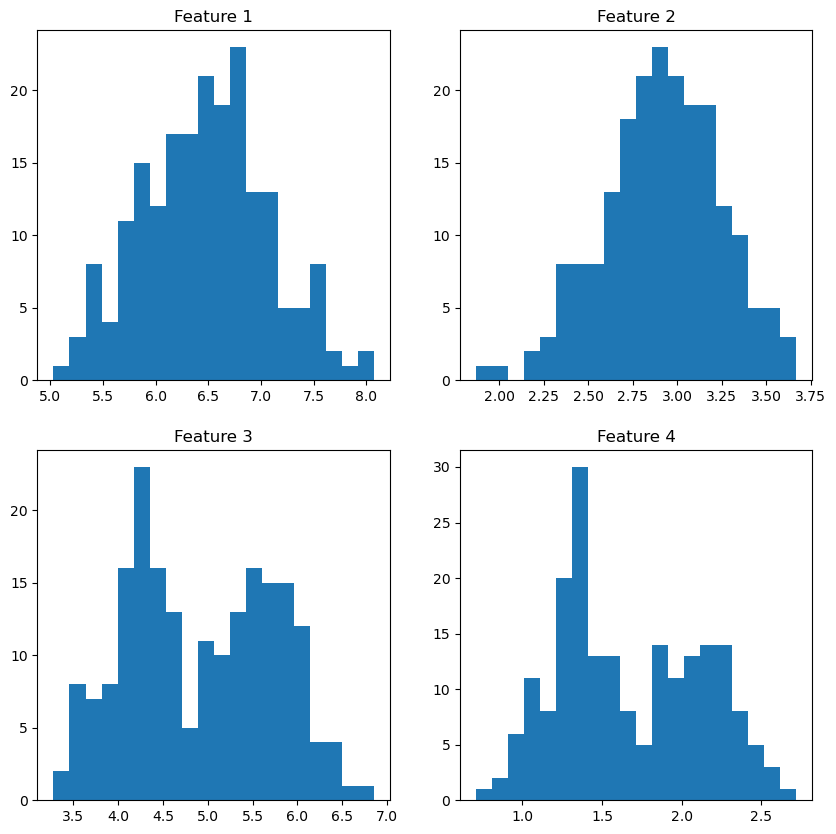

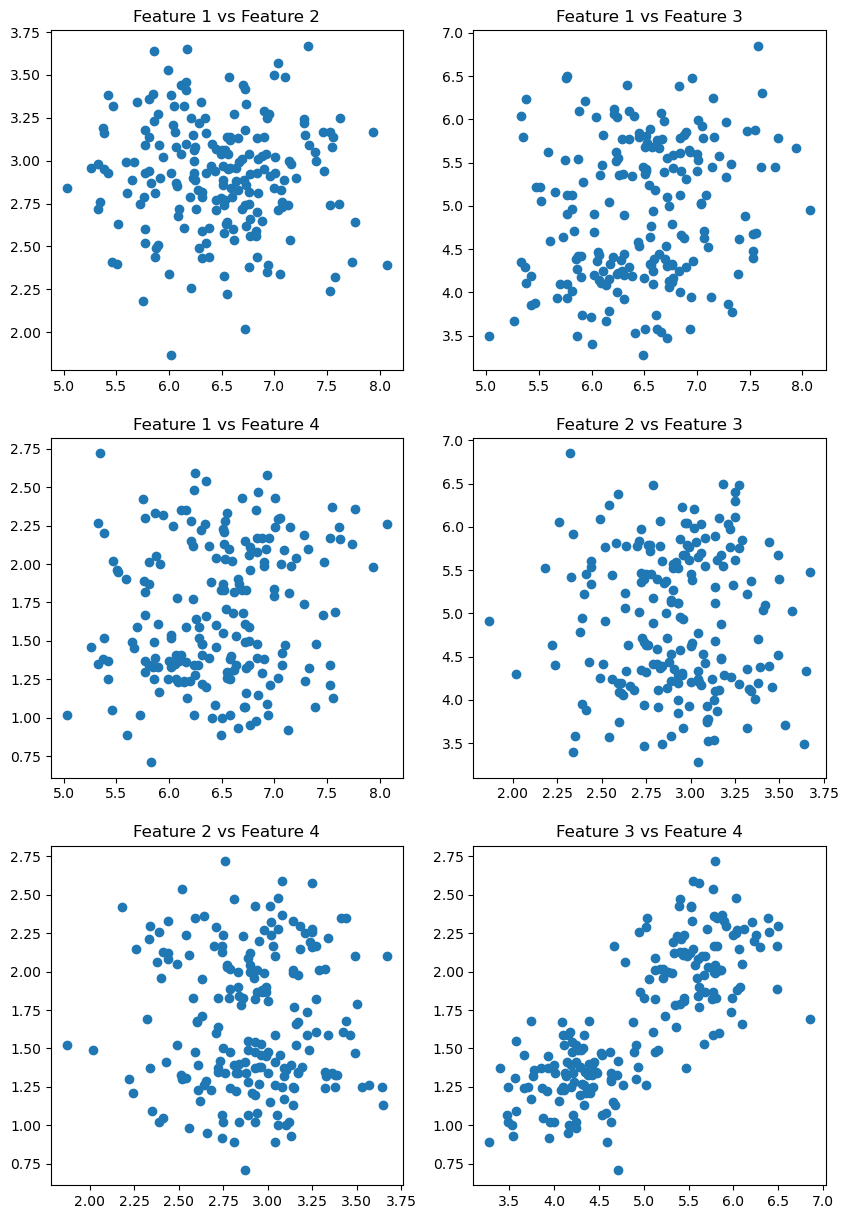

In [6]:
# plot the histogram of each feature
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.hist(f1, bins=20)
plt.title('Feature 1')
plt.subplot(2, 2, 2)
plt.hist(f2, bins=20)
plt.title('Feature 2')
plt.subplot(2, 2, 3)
plt.hist(f3, bins=20)
plt.title('Feature 3')
plt.subplot(2, 2, 4)
plt.hist(f4, bins=20)
plt.title('Feature 4')
plt.show()

# plot the scatter plot of each feature
plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 1)
plt.scatter(f1, f2)
plt.title('Feature 1 vs Feature 2')
plt.subplot(3, 2, 2)
plt.scatter(f1, f3)
plt.title('Feature 1 vs Feature 3')
plt.subplot(3, 2, 3)
plt.scatter(f1, f4)
plt.title('Feature 1 vs Feature 4')
plt.subplot(3, 2, 4)
plt.scatter(f2, f3)
plt.title('Feature 2 vs Feature 3')
plt.subplot(3, 2, 5)
plt.scatter(f2, f4)
plt.title('Feature 2 vs Feature 4')
plt.subplot(3, 2, 6)
plt.scatter(f3, f4)
plt.title('Feature 3 vs Feature 4')
plt.show()


# Minimum Risk Bayes Decision Theoretic Classifier
## Maximum likelihood

In [7]:
train1, test1 = data_loader(data_processed, 0)

In [8]:
# calculate mean and standard deviation of the data
def mean_std(data):
    mean = 0
    std = 0
    N = len(data)
    for i in range(len(data)):
        mean += data[i]
    mean = mean/N

    for i in range(len(data)):
        std += (data[i] - mean)**2
    std = (std/N)**2
    return mean, std

# calculate mean and standard deviation of the mixed data
def mean_std_mixed(data):
    # as the input data is a mix of 4 features including the class
    # we need to separate the data into 4 lists, omitting the class
    data1 = []
    data2 = []
    data3 = []
    data4 = []
    for i in range(len(data)):
        data1.append(data[i][0])
        data2.append(data[i][1])
        data3.append(data[i][2])
        data4.append(data[i][3])
    mean1, std1 = mean_std(data1)
    mean2, std2 = mean_std(data2)
    mean3, std3 = mean_std(data3)
    mean4, std4 = mean_std(data4)
    return mean1, std1, mean2, std2, mean3, std3, mean4, std4


In [9]:
# calculate covariance matrix of the data
def cov_matrix(data):
    # as the input data is a mix of 4 features including the class
    # we need to separate the data into 4 lists, omitting the class
    data1 = []
    data2 = []
    data3 = []
    data4 = []
    for i in range(len(data)):
        data1.append(data[i][0])
        data2.append(data[i][1])
        data3.append(data[i][2])
        data4.append(data[i][3])
    _, std1 = mean_std(data1)
    _, std2 = mean_std(data2)
    _, std3 = mean_std(data3)
    _, std4 = mean_std(data4)
    cov = [[std1, 0, 0, 0], [0, std2, 0, 0], [0, 0, std3, 0], [0, 0, 0, std4]]
    return cov

# covariance matrix of test1
cov_test1 = cov_matrix(test1)

# print the covariance matrix of test1
print("Covariance matrix of test1: ")
for i in range(len(cov_test1)):
    print(cov_test1[i])



Covariance matrix of test1: 
[0.09800718972099999, 0, 0, 0]
[0, 0.011908211062562504, 0, 0]
[0, 0, 0.4862328684160002, 0]
[0, 0, 0, 0.06230652496256255]


In [10]:
print(mean_std_mixed(train1))
print(mean_std_mixed(test1))

(6.470666666666663, 0.12563527510044462, 2.9140555555555556, 0.011192863493713987, 4.891388888888887, 0.4249544355033264, 1.675277777777777, 0.038963878256984705)
(6.523000000000001, 0.09800718972099999, 2.8945, 0.011908211062562504, 5.174, 0.4862328684160002, 1.6715000000000004, 0.06230652496256255)


In [11]:
test1

[[5.91, 3.09, 3.74, 1.17, 1],
 [5.83, 2.87, 4.71, 0.71, 1],
 [7.07, 2.76, 4.63, 1.34, 1],
 [6.85, 3.01, 4.66, 1.15, 1],
 [6.56, 3.04, 4.77, 1.26, 1],
 [6.31, 2.59, 4.2, 1.48, 1],
 [5.81, 3.36, 4.01, 1.34, 1],
 [6.64, 2.88, 4.44, 1.34, 1],
 [6.5, 3.06, 4.17, 1.0, 1],
 [6.02, 1.87, 4.91, 1.52, 1],
 [7.47, 2.94, 5.86, 2.01, 2],
 [6.69, 3.01, 5.39, 2.43, 2],
 [7.01, 3.02, 5.99, 2.24, 2],
 [6.38, 2.44, 5.34, 2.12, 2],
 [7.62, 3.25, 6.3, 2.16, 2],
 [6.23, 3.15, 5.62, 1.77, 2],
 [6.45, 2.71, 5.84, 1.6, 2],
 [6.83, 2.59, 6.38, 2.35, 2],
 [5.33, 2.98, 6.04, 2.27, 2],
 [6.95, 3.27, 6.48, 2.17, 2]]

In [12]:
for i in range(10):
    print(mean_std(data_loader(data_processed, i)[0][:][2]))

(3.074, 12.223582258175995)
(3.074, 12.223582258175995)
(3.074, 12.223582258175995)
(3.028, 13.135521495616)
(3.028, 13.135521495616)
(3.028, 13.135521495616)
(3.028, 13.135521495616)
(3.028, 13.135521495616)
(3.028, 13.135521495616)
(3.028, 13.135521495616)


In [13]:
# mean, std of each feature for train set 0
mean_std_mixed(data_loader(data_processed, 0)[0])

(6.470666666666663,
 0.12563527510044462,
 2.9140555555555556,
 0.011192863493713987,
 4.891388888888887,
 0.4249544355033264,
 1.675277777777777,
 0.038963878256984705)

In [14]:
# mean, std of each feature for test set 0
mean_std_mixed(data_loader(data_processed, 0)[1])

(6.523000000000001,
 0.09800718972099999,
 2.8945,
 0.011908211062562504,
 5.174,
 0.4862328684160002,
 1.6715000000000004,
 0.06230652496256255)

# With math

In [27]:
import math
import numpy as np

In [32]:
import math

# Step 1: Estimate Parameters (Mean vectors and Covariance matrices)
def estimate_parameters(data):
    num_features = len(data[0]) - 1  # Exclude the last column (class label)
    num_classes = max(data, key=lambda x: x[-1])[-1] # max is the number of classes

    mean_vectors = {i: [0.0] * num_features for i in range(1, num_classes + 1)} # Mean vectors for each class
    covariance_matrices = {i: [[0.0 for _ in range(num_features)] for _ in range(num_features)] for i in range(1, num_classes + 1)} # Covariance matrices for each class 
    class_counts = {i: 0 for i in range(1, num_classes + 1)} # Count the number of samples for each class

    # Calculate the sum of feature values for each class
    for row in data: # Iterate over the samples
        class_label = int(row[-1]) # The last column is the class label
        class_counts[class_label] += 1 # Count the number of samples for each class
        for i in range(num_features): # Iterate over the features
            mean_vectors[class_label][i] += row[i] # Sum the feature values for each class

    # Calculate the mean vectors
    for class_label in mean_vectors: # Iterate over the classes
        for i in range(num_features): # Iterate over the features
            mean_vectors[class_label][i] /= class_counts[class_label] # Divide the sum by the number of samples

    # Calculate the covariance matrices
    for row in data: # Iterate over the samples
        class_label = int(row[-1]) # The last column is the class label
        for i in range(num_features):
            for j in range(num_features):
                covariance_matrices[class_label][i][j] += (row[i] - mean_vectors[class_label][i]) * (row[j] - mean_vectors[class_label][j])

    for class_label in covariance_matrices: # Iterate over the classes
        for i in range(num_features): 
            for j in range(num_features):
                covariance_matrices[class_label][i][j] /= (class_counts[class_label] - 1) # Divide the sum by the number of samples - 1

    return mean_vectors, covariance_matrices

# Step 2: Minimum Risk Bayes Decision Theoretic Classifier
def multivariate_normal_pdf(x, mean, covariance):
    k = len(x) # Number of features
    coefficient = 1.0 / ((2 * math.pi) ** (k / 2) * determinant_4x4(covariance)) ** 0.5 # Calculate the coefficient

    # Calculate (x - mean)
    x_minus_mean = [x[i] - mean[i] for i in range(k)]

    # Calculate the inverse of the covariance matrix
    inv_covariance = inverse_4x4(covariance)

    # Calculate (x - mean)^T * inv(covariance) * (x - mean)
    intermediate = [0.0] * k
    for i in range(k):
        for j in range(k):
            intermediate[i] += x_minus_mean[j] * sum(inv_covariance[j][m] * x_minus_mean[m] for m in range(k))

    # Calculate the Mahalanobis distance squared
    mahalanobis_dist_sq = sum(x_minus_mean[i] * intermediate[i] for i in range(k))

    # Calculate the exponent without using math.exp
    exponent = -0.5 * mahalanobis_dist_sq
    exp = 1.0
    for _ in range(100):  # We approximate exp using a Taylor series with 100 terms
        exp += exponent
        exponent *= -0.5 * mahalanobis_dist_sq / (_ + 1)

    return coefficient * exp

def determinant_4x4(matrix):
    # Calculate the determinant of a 4x4 matrix
    a, b, c, d = matrix[0]
    e, f, g, h = matrix[1]
    i, j, k, l = matrix[2]
    m, n, o, p = matrix[3]

    return (a * determinant_3x3([[f, g, h], [j, k, l], [n, o, p]])
            - b * determinant_3x3([[e, g, h], [i, k, l], [m, o, p]])
            + c * determinant_3x3([[e, f, h], [i, j, l], [m, n, p]])
            - d * determinant_3x3([[e, f, g], [i, j, k], [m, n, o]]))

def determinant_3x3(matrix):
    # Calculate the determinant of a 3x3 matrix
    a, b, c = matrix[0]
    d, e, f = matrix[1]
    g, h, i = matrix[2]

    return (a * (e * i - f * h)
            - b * (d * i - f * g)
            + c * (d * h - e * g))

def inverse_4x4(matrix):
    # Calculate the inverse of a 4x4 matrix
    a, b, c, d = matrix[0]
    e, f, g, h = matrix[1]
    i, j, k, l = matrix[2]
    m, n, o, p = matrix[3]

    det = determinant_4x4(matrix)

    inv_matrix = [
        [(f * k - g * j) / det, (c * j - b * k) / det, (b * g - c * f) / det, (b * (f * p - g * o) + c * (h * o - e * p) + d * (e * g - h * f)) / det],
        [(g * i - h * k) / det, (a * k - c * i) / det, (c * h - a * g) / det, (a * (g * p - h * o) + c * (d * o - h * l) + d * (h * i - e * p)) / det],
        [(h * j - f * i) / det, (b * i - a * j) / det, (a * f - b * h) / det, (a * (f * l - j * i) + b * (h * i - e * l) + d * (e * j - f * h)) / det],
        [(f * o - g * n) / det, (c * n - b * o) / det, (b * g - c * f) / det, (b * (f * l - j * i) + c * (h * i - e * l) + d * (h * j - e * k)) / det]
    ]

    return inv_matrix

def minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities):
    num_classes = len(mean_vectors)
    posterior_probabilities = [0] * num_classes

    for class_label in range(1, num_classes + 1):
        mean_vector = mean_vectors[class_label]
        covariance_matrix = covariance_matrices[class_label]

        # Calculate (x - mean)
        x_minus_mean = [test_sample[i] - mean_vector[i] for i in range(len(test_sample))]

        # Calculate the determinant of the covariance matrix
        det_covariance = determinant_4x4(covariance_matrix)

        # Calculate the inverse of the covariance matrix
        inv_covariance = inverse_4x4(covariance_matrix)

        # Calculate the Mahalanobis distance squared
        mahalanobis_dist_sq = sum(x_minus_mean[i] * sum(inv_covariance[i][j] * x_minus_mean[j] for j in range(len(x_minus_mean))) for i in range(len(x_minus_mean)))

        # Calculate the log-likelihood and posterior probability without using math.log
        log_likelihood = -0.5 * (mahalanobis_dist_sq + sum([math.log(inv_covariance[i][i]) for i in range(len(x_minus_mean))]))
        posterior_probabilities[class_label - 1] = math.log(prior_probabilities[class_label]) + log_likelihood

    # Choose the class with the highest posterior probability as the predicted label
    predicted_label = posterior_probabilities.index(max(posterior_probabilities)) + 1

    return predicted_label

# Step 3: 10% Cross Validation
def cross_validation(data, num_folds=10):
    fold_size = len(data) // num_folds
    accuracy = []

    for i in range(num_folds):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size
        test_set = data[start_idx:end_idx]
        train_set = data[:start_idx] + data[end_idx:]

        mean_vectors, covariance_matrices = estimate_parameters(train_set)

        correct_predictions = 0
        for sample in test_set:
            test_sample = sample[:-1]  # Exclude the class label from the test sample
            true_label = int(sample[-1])
            predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
            if predicted_label == true_label:
                correct_predictions += 1

        accuracy.append(correct_predictions / fold_size)

    avg_accuracy = sum(accuracy) / num_folds
    return avg_accuracy

# Step 4: Display Results (Mean vectors, Covariance matrices, Confusion matrix, Error estimates, Classification information)
def display_results(mean_vectors, covariance_matrices, confusion_matrix):
    print("Mean Vectors:")
    for class_label, mean_vector in mean_vectors.items():
        print(f"Class {class_label}: {mean_vector}")

    print("\nCovariance Matrices:")
    for class_label, covariance_matrix in covariance_matrices.items():
        print(f"Class {class_label}:")
        for row in covariance_matrix:
            print(row)

    print("\nConfusion Matrix:")
    for row in confusion_matrix:
        print(row)

    total_samples = sum(sum(row) for row in confusion_matrix)
    correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
    error_rate = (total_samples - correct_predictions) / total_samples
    print(f"\nError Rate: {error_rate:.2f}")





In [35]:
data = data_loader(data_processed, 0)[1]
# Assuming equal prior probabilities for each class (not hard-coded)
num_classes = max(data, key=lambda x: x[-1])[-1]
prior_probabilities = {i: 1 / num_classes for i in range(1, num_classes + 1)}

mean_vectors, covariance_matrices = estimate_parameters(data)
confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
for sample in data:
    true_label = int(sample[-1])
    test_sample = sample[:-1]
    predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
    confusion_matrix[true_label - 1][predicted_label - 1] += 1
print(confusion_matrix)

    

ValueError: math domain error

In [ ]:
# Step 5: Main code
# Example data
data = test1
# Assuming equal prior probabilities for each class (not hard-coded)
num_classes = max(data, key=lambda x: x[-1])[-1]
prior_probabilities = {i: 1 / num_classes for i in range(1, num_classes + 1)}

# Perform cross-validation and display the results
accuracy = cross_validation(data)
print(f"Average Accuracy: {accuracy:.2f}")

# Estimate mean vectors and covariance matrices using the entire data
mean_vectors, covariance_matrices = estimate_parameters(data)

# Calculate confusion matrix using the entire data
confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
for sample in data:
    true_label = int(sample[-1])
    test_sample = sample[:-1]
    predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
    confusion_matrix[true_label - 1][predicted_label - 1] += 1

display_results(mean_vectors, covariance_matrices, confusion_matrix)


# With math and numpy

In [ ]:
import math
import numpy as np

# Step 1: Estimate Parameters (Mean vectors and Covariance matrices)
def estimate_parameters(data):
    num_features = len(data[0]) - 1  # Exclude the last column (class label)
    num_classes = max(data, key=lambda x: x[-1])[-1]  # Assuming class labels are 1-indexed

    mean_vectors = {i: np.zeros(num_features) for i in range(1, num_classes + 1)}
    covariance_matrices = {i: np.zeros((num_features, num_features)) for i in range(1, num_classes + 1)}
    class_counts = {i: 0 for i in range(1, num_classes + 1)}

    # Calculate the sum of feature values for each class
    for row in data:
        class_label = int(row[-1])
        class_counts[class_label] += 1
        for i in range(num_features):
            mean_vectors[class_label][i] += row[i]

    # Calculate the mean vectors
    for class_label in mean_vectors:
        mean_vectors[class_label] /= class_counts[class_label]

    # Calculate the covariance matrices
    for row in data:
        class_label = int(row[-1])
        x_minus_mean = row[:-1] - mean_vectors[class_label]
        x_minus_mean = x_minus_mean.reshape((-1, 1))  # Convert to column vector
        covariance_matrices[class_label] += np.dot(x_minus_mean, x_minus_mean.T)

    for class_label in covariance_matrices:
        covariance_matrices[class_label] /= (class_counts[class_label] - 1)

    return mean_vectors, covariance_matrices

# Step 2: Minimum Risk Bayes Decision Theoretic Classifier
def multivariate_normal_pdf(x, mean, covariance):
    k = len(x)
    coefficient = 1.0 / ((2 * np.pi) ** (k / 2) * np.linalg.det(covariance))

    x_minus_mean = x - mean

    # Calculate the Mahalanobis distance squared
    mahalanobis_dist_sq = np.dot(x_minus_mean, np.linalg.solve(covariance, x_minus_mean))

    # Calculate the exponent
    exponent = -0.5 * mahalanobis_dist_sq

    return coefficient * np.exp(exponent)


# Step 3: 10% Cross Validation
def cross_validation(data, num_folds=10):
    fold_size = len(data) // num_folds
    accuracy = []

    for i in range(num_folds):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size
        test_set = data[start_idx:end_idx]
        train_set = data[:start_idx] + data[end_idx:]

        mean_vectors, covariance_matrices = estimate_parameters(train_set)

        correct_predictions = 0
        for sample in test_set:
            test_sample = sample[:-1]  # Exclude the class label from the test sample
            true_label = int(sample[-1])
            predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
            if predicted_label == true_label:
                correct_predictions += 1

        accuracy.append(correct_predictions / fold_size)

    avg_accuracy = sum(accuracy) / num_folds
    return avg_accuracy

# Step 4: Display Results (Mean vectors, Covariance matrices, Confusion matrix, Error estimates, Classification information)
def display_results(mean_vectors, covariance_matrices, confusion_matrix):
    print("Mean Vectors:")
    for class_label, mean_vector in mean_vectors.items():
        print(f"Class {class_label}: {mean_vector}")

    print("\nCovariance Matrices:")
    for class_label, covariance_matrix in covariance_matrices.items():
        print(f"Class {class_label}:")
        for row in covariance_matrix:
            print(row)

    print("\nConfusion Matrix:")
    for row in confusion_matrix:
        print(row)

    total_samples = sum(sum(row) for row in confusion_matrix)
    correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
    error_rate = (total_samples - correct_predictions) / total_samples
    print(f"\nError Rate: {error_rate:.2f}")

# Step 5: Main code
# Example data
data = test1

# Assuming equal prior probabilities for each class (not hard-coded)
num_classes = max(data, key=lambda x: x[-1])[-1]
prior_probabilities = {i: 1 / num_classes for i in range(1, num_classes + 1)}

# Perform cross-validation and display the results
accuracy = cross_validation(data)
print(f"Average Accuracy: {accuracy:.2f}")

# Estimate mean vectors and covariance matrices using the entire data
mean_vectors, covariance_matrices = estimate_parameters(data)

# Calculate confusion matrix using the entire data
confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
for sample in data:
    true_label = int(sample[-1])
    test_sample = sample[:-1]
    predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
    confusion_matrix[true_label - 1][predicted_label - 1] += 1

display_results(mean_vectors, covariance_matrices, confusion_matrix)


ValueError: math domain error